# Sedimentation Rate Analysis

### Load dataset and declare indices of variables

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import geo_preprocess3
from tabulate import tabulate
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import minimize

% matplotlib inline

# load data
data = np.genfromtxt('alldata_new', delimiter='')

# define column index for 19 variables
lon_ind = 0
lat_ind = 1
sedthick_ind = 2
sedrate_ind = 3   
age_ind = 4
passive_dis_ind = 5
amazon_dis_ind = 6
congo_dis_ind = 7
gange_dis_ind = 8
godava_dis_ind = 9
indus_dis_ind = 10
magdalena_dis_ind = 11
mahan_dis_ind = 12
missi_dis_ind = 13
narma_dis_ind = 14
niger_dis_ind = 15
orin_dis_ind = 16
paleo_dis_ind = 17
parana_dis_ind = 18

river_indices = np.array([amazon_dis_ind, congo_dis_ind, gange_dis_ind, godava_dis_ind, indus_dis_ind, 
                          magdalena_dis_ind, mahan_dis_ind, missi_dis_ind, narma_dis_ind, niger_dis_ind,
                          orin_dis_ind, paleo_dis_ind, parana_dis_ind])

river_names = np.array(['Amazon', 'Congo', 'Ganges-Bramaputra', 'Godavari-Krishna', 'Indus',
                        'Magdalena', 'Mahanadi', 'Mississipi', 'Narma', 'Niger', 'Orinoco',
                        'Paleo-Congo', 'Parana'])

print(river_indices)
data.shape

[ 6  7  8  9 10 11 12 13 14 15 16 17 18]


(34773, 19)

### Declare the regressor 

In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso

# number of splits for LongFold cross validation
n_splits = 3

# regressor
regressor = Pipeline(steps=[('stand', StandardScaler()),
                            ('poly', PolynomialFeatures(degree=3)),
                            ('linear', Lasso(alpha=0.01))])

### Remove records where rate is nan, age is nan, and distance to passive is nan

In [25]:
# remove records where thick is zero
y = data[:, sedthick_ind]
data = data[~(y == 0)]

# remove records where age is nan
y = data[:, age_ind]
data = data[~np.isnan(y)]

# remove records where distance to passive margin is nan
y = data[:, passive_dis_ind]
data = data[~np.isnan(y)]

# remove records where sediment rate is nan or 0
sedrate = data[:, sedrate_ind]
index = (~np.isnan(sedrate)) & (~(sedrate == 0))
data = data[index]

# the final dataset has dimension as follows
data.shape

(27306, 19)

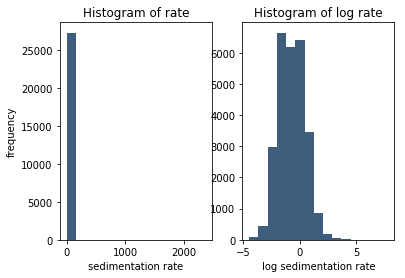

In [26]:
# plot histogram for sedimentation rate and log sedimentation rate
f, (ax1, ax2) = plt.subplots(1,2)
ax1.hist(data[:, [sedrate_ind]], color="#3F5D7D", bins=15)
ax2.hist(np.log(data[:, [sedrate_ind]]), color="#3F5D7D", bins=15)
ax1.set_xlabel('sedimentation rate')
ax1.set_ylabel('frequency')
ax2.set_xlabel('log sedimentation rate')
ax1.set_title('Histogram of rate')
ax2.set_title('Histogram of log rate')
plt.show()

In [27]:
# generate inverse of rivers and mask rivers distance greater than 1500km
def generate_irivers():
    rivers = data[:, river_indices]

    rivers[rivers > 1500.0] = np.nan

    rivers[np.isnan(rivers)] = np.inf
    
    return 1.0 / rivers

In [31]:
# generate various plots of goodness of fit
def plot_goodness_fit(lon, lat, yactual, ypred):

    # scatterplot of ypred and yactual
    geo_preprocess3.feature_scatter(yactual, ypred, 
                                   xlim1=-4,
                                   xlim2=3,
                                   ylim1=-4,
                                   ylim2=3)
    # global map of y actual
    geo_preprocess3.draw_global(c=yactual, 
                                title='actual log sediment rate',
                                longitude=lon, latitude=lat, 
                                vmin=-4, 
                                vmax=3)
    
    # global map of y predicted
    geo_preprocess3.draw_global(c=ypred, 
                           title='predicted log sediment rate',
                           longitude=lon, latitude=lat, 
                           vmin=-4, 
                           vmax=3)
    
    # global map of y actual - y predicted
    geo_preprocess3.draw_global(c= (sedrate - np.exp(ypred)), 
                       title='actual rate minus predicted rate',
                       longitude=lon, latitude=lat, 
                       vmin=-10, 
                       vmax=10)

### Train and Predict - with all rivers

In [11]:
irivers = generate_irivers()

# data1 only has feature longitude, latitude, age and distance to passive margin
data1 = data[:, [lon_ind, lat_ind, age_ind, passive_dis_ind]]

# extract sedimentation rate
sedrate = data[:, sedrate_ind]

def compute_r2(weights):
    """
    Function to be optimzed later.
    
    Parameters
    ----------
    weights : ndarray (d, 1); the weights for rivers
    
    Return
    ------
    nr2 : float; the negative r square
    """
    nr2 = 0.0
    
    # square weights to make sure they are positive
    weights = weights ** 2

    # obtain weighted sum of inverse of distance to rivers
    ws_river = np.sum(irivers * weights, axis=1)
    
    # integrate all features and target variable into one matrix - data2
    data2 = np.c_[data1, ws_river, sedrate]
    
    # do regression 
    # - this is a function in file geo_preprocess3
    # - it use longitude to do LongFold cross validation
    # - logy=True means apply log transform to target variable y
    ypred,_ = geo_preprocess3.regression(data=data2, 
                    regressor=regressor, 
                    n_splits=n_splits,
                    lon_ind=lon_ind, 
                    lat_ind=lat_ind, 
                    y_ind=-1,
                    logy=True)
    
    yactual = np.log(sedrate)
    
    # obtain negative r square of actual log rate and predicted log rate
    nr2 = -1.0 * r2_score(yactual, ypred)
    
    # print nr2 to see the process of optimization
    print(nr2)
    return nr2



# initial guess of weights; seed fix random number so that we can recover the result
np.random.seed(0)
w0 = np.random.random(13)

# here I comment out the command for launching optmization, it takes long time to converge

res = minimize(fun=compute_r2,
               x0=w0,
               method='COBYLA',
               tol=1e-6,
               options={'maxiter': 10000,
                        'disp': True}
)
res.x
opt = res.x
opt = opt ** 2
print(tabulate(np.vstack([river_names, opt]).T))

/home/xinyue/.virtualenvs/sediment/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in greater


-0.453568740153
1.18655318837
17.8261549387
-0.451837548863


/home/xinyue/.virtualenvs/sediment/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


27.7888946011
4.05221032427
4.02134042769
13.9137657942
-0.273252515036
0.0225780473684
840.150896701
-0.0257026958687
168.736114895
-0.39478101212
-0.427846267678
-0.45410678404
-0.451920102429
-0.451120634527
-0.455151544278
-0.45255777443
-0.455448104041
-0.455531173984
-0.455331829851
-0.454809528355
-0.453567004955
-0.454719721193
-0.454971950221
-0.455309249471
-0.454557665837
-0.456220293987
-0.456526159537
-0.455509797397
-0.455628724735
-0.455716534926
-0.456810421605
-0.455807672423
-0.456145052229
-0.45342308148
-0.456659198192
-0.455847435329
-0.456488623723
-0.455139809981
-0.457081512706
-0.456151100929
-0.456915870421
-0.456339231137
-0.456587321451
-0.455802707976
-0.456688967235
-0.45709580219
-0.456461380871
-0.456934928324
-0.45814913798
-0.455576711009
-0.457884146941
-0.458336623313
-0.458423637238
-0.458412489454
-0.458519842807
-0.45838541999
-0.458444109637
-0.458409767316
-0.458691248265
-0.45872059671
-0.458891500023
-0.458634831718
-0.458928862914
-0.45859470

### Use optimized weights to generate feature distance to rivers

In [12]:
# This is the optimal weights from optimization
opt_weights = np.array([
        0.441015,
        0.055656,
        0.248724,
        0.208447,
        0.322598,
        0.0114151,
        0.17303,
        1.07033,
        0.460401,
        0.133084,
        0.158856,
        0.0442793,
        0.312234
    ])

### Train model and do regression, plot goodness of fit

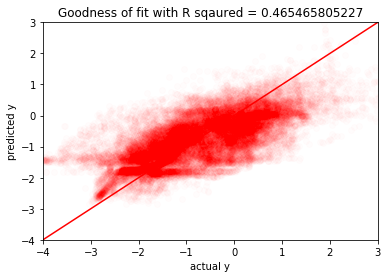

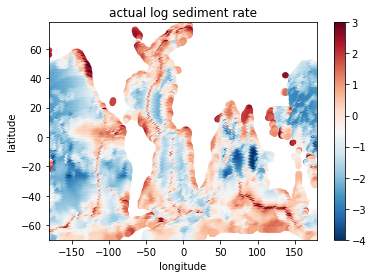

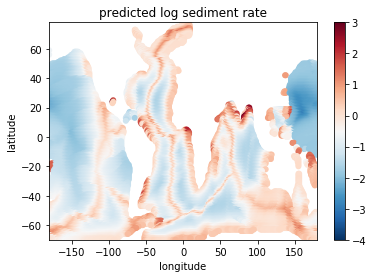

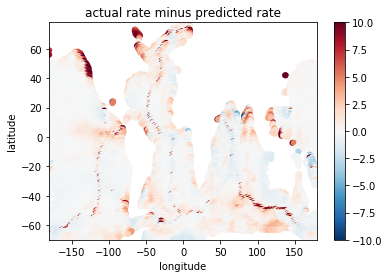

In [32]:
np.seterr(invalid='ignore')
irivers = generate_irivers()

# use opt_weights to get optimal weighted sum of inverse of distance to rivers
ws_river = np.sum(irivers * opt_weights, 1)

# define the feature matrix along with target variable - sedrate
data1 = data[:, [lon_ind, lat_ind, age_ind, passive_dis_ind]]
sedrate = data[:, sedrate_ind]
data2 = np.c_[data1, ws_river, sedrate]

# regression, with optimal weighted sum of inverse of distance to rivers
# return predicted log rate and trained regressor
ypred, _ =  geo_preprocess3.regression(data=data2, 
                                        regressor=regressor, 
                                        n_splits=3,
                                        lon_ind=lon_ind, 
                                        lat_ind=lat_ind, 
                                        y_ind=-1,
                                        logy=True)

# extract longitude, latitude and sedrate for plots
lon = data1[:,lon_ind]
lat = data1[:,lat_ind]
yactual = np.log(sedrate)

plot_goodness_fit(lon, lat, yactual, ypred)

In [ ]:
def period_pred(c_river_indices, period_name, period_explan, period_index):
    """
    Conduct prediction for certain time period and generate plots.
    
    Parameters
    ----------
    c_river_indice: ndarray (m, 1)
                    the indice of existed rivers at this time period
    period_name : string; e.g. '26Ma'
    period_explan : string; e.g. 'exclude Paleo'
    period_index : ndarray (n, 1)
                   it is used to remove records where age is outside the time period
    """
    # select subset of data based on period_index
    datapd = data[period_index]

    # extract rivers from datapd, impute nan with infinty, and apply inverse of distance to rivers
    rivers = datapd[:, river_indices]
    rivers[np.isnan(rivers)] = np.inf
    irivers = 1.0 / rivers

    # in this case, use all rivers to get weighted sum of inverse of distance to rivers
    ws_river = np.sum(irivers * opt_weights, 1)   
    
    # construct matrix for regression
    data1 = datapd[:, [lon_ind, lat_ind, age_ind, passive_dis_ind]]
    sedrate = datapd[:, sedrate_ind]
    data2 = np.c_[data1, ws_river]
    
    # prediction1 - with weighted sum of 13 rivers
    ypred1 =  geo_preprocess3.predict(data2, regressor_trained)
    
    # extract existed rivers from datapd, impute nan with infinty, and apply inverse of distance to rivers
    rivers = datapd[:, c_river_indices]
    rivers[np.isnan(rivers)] = np.inf
    irivers = 1.0 / rivers
    
    # extract corresponding weights
    weights = opt_weights[c_river_indices-6]
    
    # in this case, only use existed rivers to get weighted sum of inverse of distance to rivers
    ws_river2 = np.sum(irivers * weights, 1)


    # construct matrix for regression
    data1 = datapd[:, [lon_ind, lat_ind, age_ind, passive_dis_ind]]
    sedrate = datapd[:, sedrate_ind]
    data2 = np.c_[data1, ws_river2]

    # prediction2 - with weighted sum of existed rivers
    ypred2 =  geo_preprocess3.predict(data2, regressor_trained)

    # longitude and latitude for plot
    lon = data1[:,lon_ind]
    lat = data1[:,lat_ind]
    yactual = np.log(sedrate)
    
    # global map of actual log sediment rate
    geo_preprocess3.draw_global(c=np.log(sedrate), 
                           title='actual log sediment rate - '+period_name,
                           longitude=lon, latitude=lat, 
                           vmin=-4, 
                           vmax=3)

    # global map of predicted sediment rate with all features
    geo_preprocess3.draw_global(c=ypred1, title='predicted log sediment rate - '+period_name +' (with all features)',
                           longitude=lon, latitude=lat,
                           vmin=-4, 
                           vmax=3)

    # global map of predicted sediment rate with existed rivers
    geo_preprocess3.draw_global(c=ypred2, title='predicted log sediment rate - '+period_name+' '+period_explan,
                           longitude=lon, latitude=lat,
                           vmin=-4, 
                           vmax=3)

    # global map of difference between prediction with all rivers and will existed rivers
    geo_preprocess3.draw_global(c= (np.exp(ypred1) - np.exp(ypred2)), 
                            title='pred with all rivers minus pred without certain rivers-'+period_name,
                           longitude=lon, latitude=lat,
                           vmin=-1, 
                           vmax=1)

    # global map of feature weighted summation of distance to rivers
    geo_preprocess3.draw_global(c=ws_river2, title='optimal weighted summation of distance to rivers - '+period_name,
                           longitude=lon, latitude=lat,
                           vmin=0, 
                           vmax=0.008,
                           cmap='Reds')
    diff = (np.exp(ypred1) - np.exp(ypred2))
    
    diff_nz = diff[~(diff == 0.0)]
    print('number of grids where two prediction are different = ' + str(diff_nz.shape[0]))
    print('mean of difference between two predictions = ' + str(np.mean(diff_nz)))
    print('standard deviation of difference between two predictions = ' + str(np.std(diff_nz)))
    return diff

### Prediction1 - present (exlcude Paleo-Congo)

In [ ]:
age = data[:, age_ind]

# existed river indices
c_river_indices = np.array([amazon_dis_ind, congo_dis_ind, gange_dis_ind, godava_dis_ind, indus_dis_ind, 
                          magdalena_dis_ind, mahan_dis_ind, missi_dis_ind, narma_dis_ind, niger_dis_ind,
                          orin_dis_ind, parana_dis_ind])
period_index = (age > 0.0)
diff = period_pred(c_river_indices, 'present', '(exclude Paleo)', period_index)

### Prediction2 - 26Ma (remove Amazon, Orinoco, Congo, Paleo-Congo)

In [ ]:
# existed river indices
c_river_indices = np.array([gange_dis_ind, godava_dis_ind, indus_dis_ind, 
                          magdalena_dis_ind, mahan_dis_ind, missi_dis_ind, narma_dis_ind, niger_dis_ind,
                          parana_dis_ind])
period_index = (age > 26.0)
diff = period_pred(c_river_indices, '26Ma', '(remove Amazon, Orinoco, Congo, Paleo)', period_index)

### Prediction3 - 56Ma (only Parana, Paleo-Congo, Niger)

In [ ]:
# existed river indices
c_river_indices = np.array([niger_dis_ind,paleo_dis_ind, parana_dis_ind])

period_index = (age > 56.0)
diff=period_pred(c_river_indices, '56Ma', '(Parana, Paleo-Congo, Niger)', period_index)

### Feature Analysis - Age

In [ ]:
# regressor
regressor = Pipeline(steps=[('stand', StandardScaler()),
                            ('poly', PolynomialFeatures(degree=3)),
                            ('linear', Lasso(alpha=0.01))])

# global map of age
age = data[:, age_ind]
sedrate = data[:, sedrate_ind]
geo_preprocess3.draw_global(c=age, 
                            title='Global map of age',
                            longitude=data[:, lon_ind],
                            latitude=data[:, lat_ind],
                            vmin = 0,
                            vmax=197, 
                            cmap='Blues')

# learn relationship between age and sedrate
regressor.fit(age.reshape(-1,1), np.log(sedrate))
fea_min = np.min(age)
fea_max = np.max(age)
fea_query = np.linspace(fea_min, fea_max, 20)[:, np.newaxis]
fea_pred = regressor.predict(fea_query)

# scatterplot of age and log sedrate
plt.plot(age, np.log(data[:, sedrate_ind]), 'go', alpha=0.05, lw=0)
plt.plot(fea_query, fea_pred, color='b')
plt.title('scatterplot of age and log sedrate with regression line')
plt.xlabel('age')
plt.ylabel('log sedrate')
plt.ylim([-6, 8])
plt.show()

### Feature Analysis - Distance to passive margin

In [ ]:
# regressor
regressor = Pipeline(steps=[('stand', StandardScaler()),
                            ('poly', PolynomialFeatures(degree=3)),
                            ('linear', Lasso(alpha=0.01))])

# global map of distance to passive margine
passive_dis = data[:, passive_dis_ind]
sedrate = data[:, sedrate_ind]
geo_preprocess3.draw_global(c=passive_dis, 
                            title='Global map of distance to passive margin',
                            longitude=data[:, lon_ind],
                            latitude=data[:, lat_ind],
                            vmin = 0,
                            vmax=8000,
                            cmap='Blues')

# learn relationship between distance to passive margine and sedrate
regressor.fit(passive_dis.reshape(-1,1), np.log(sedrate))
fea_min = np.min(passive_dis)
fea_max = np.max(passive_dis)
fea_query = np.linspace(fea_min, fea_max, 20)[:, np.newaxis]
fea_pred = regressor.predict(fea_query)

# scatterplot of distance to passive margine and log sedrate
plt.plot(passive_dis, np.log(data[:, sedrate_ind]), 'go', alpha=0.05, lw=0)
plt.plot(fea_query, fea_pred, color='b')
plt.title('scatterplot of distance to passive margin and log sedrate with regression line')
plt.xlabel('distance to passive margin')
plt.ylabel('log sedrate')
plt.ylim([-6, 8])
plt.show()

### Feature Analysis - Weighted sum of inverse of distance to rivers

In [ ]:
# regressor
regressor = Pipeline(steps=[('stand', StandardScaler()),
                            ('poly', PolynomialFeatures(degree=3)),
                            ('linear', Lasso(alpha=0.01))])

# global map of weighted sum of inverse of distance to rivers
rivers = data[:, river_indices]
rivers[np.isnan(rivers)] = np.inf
irivers = 1.0 / rivers
ws_river = np.sum(irivers * opt_weights, 1)

sedrate = data[:, sedrate_ind]
geo_preprocess3.draw_global(c=ws_river, 
                            title='Global map of weighted sum of inverse of distance to rivers',
                            longitude=data[:, lon_ind],
                            latitude=data[:, lat_ind],
                            vmin = 0,
                            vmax=0.01,
                            cmap='Blues')

# learn relationship between weighted sum of inverse of distance to rivers and sedrate
regressor.fit(ws_river.reshape(-1,1), np.log(sedrate))
fea_min = np.min(ws_river)
fea_max = np.max(ws_river)
fea_query = np.linspace(fea_min, fea_max, 20)[:, np.newaxis]
fea_pred = regressor.predict(fea_query)

# scatterplot of weighted sum of inverse of distance to rivers and log sedrate
plt.plot(ws_river, np.log(data[:, sedrate_ind]), 'go', alpha=0.05, lw=0)
plt.plot(fea_query, fea_pred, color='b')
plt.title('scatterplot of weighted sum of inverse of distance to rivers and log sedrate with regression line')
plt.xlabel('weighted sum of inverse of distance to rivers')
plt.ylabel('log sedrate')
plt.ylim([-6, 8])
plt.show()

### Feature Analysis - Age and Distance to passive margin

In [ ]:
# regressor
regressor = Pipeline(steps=[('stand', StandardScaler()),
                            ('poly', PolynomialFeatures(degree=2)),
                            ('linear', Lasso(alpha=0.01))])

rivers = data[:, river_indices]
rivers[np.isnan(rivers)] = np.inf
irivers = 1.0 / rivers
ws_river = np.sum(irivers * opt_weights, )

data1 = data[:, [lon_ind, lat_ind, age_ind, passive_dis_ind]]
sedrate = data[:, sedrate_ind]
data2 = np.c_[data1, irivers, sedrate]

### Treat 13 distance to rivers as 13 features instead of one feature

In [ ]:
# regressor
regressor = Pipeline(steps=[('stand', StandardScaler()),
                            ('poly', PolynomialFeatures(degree=2)),
                            ('linear', Lasso(alpha=0.01))])

rivers = data[:, river_indices]
rivers[np.isnan(rivers)] = np.inf
irivers = 1.0 / rivers

data1 = data[:, [lon_ind, lat_ind, age_ind, passive_dis_ind]]
sedrate = data[:, sedrate_ind]
data2 = np.c_[data1, irivers, sedrate]

ypred, regressor_trained =  geo_preprocess3.regression(data=data2, 
                                    regressor=regressor, 
                                    n_splits=3,
                                    lon_ind=lon_ind, 
                                    lat_ind=lat_ind, 
                                    y_ind=-1,
                                    logy=True)


# extract longitude, latitude and sedrate for plots
lon = data1[:,lon_ind]
lat = data1[:,lat_ind]
yactual = np.log(sedrate)

# scatterplot of ypred and yactual
geo_preprocess3.feature_scatter(yactual, ypred, 
                               xlim1=-4,
                               xlim2=3,
                               ylim1=-4,
                               ylim2=3)

# global map of actual log sediment rate
geo_preprocess3.draw_global(c=np.log(sedrate), 
                       title='actual log sediment rate',
                       longitude=lon, latitude=lat, 
                       vmin=-4, 
                       vmax=3)

# global map of predicted log sediment rate from regression
geo_preprocess3.draw_global(c=ypred, 
                       title='predicted log sediment rate - 13 rivers as 13 features',
                       longitude=lon, latitude=lat, 
                       vmin=-4, 
                       vmax=3)

# global map of difference between actual and predicted sediment rate
# i.e. actual sediment rate - exp(predicted log sediment rate)
geo_preprocess3.draw_global(c= (sedrate - np.exp(ypred)), 
                       title='actual rate minus predicted rate',
                       longitude=lon, latitude=lat, 
                       vmin=-10, 
                       vmax=10)